# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [216]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [3]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    
def bold(text):
    return f"{color.BOLD}{text}{color.END}"

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

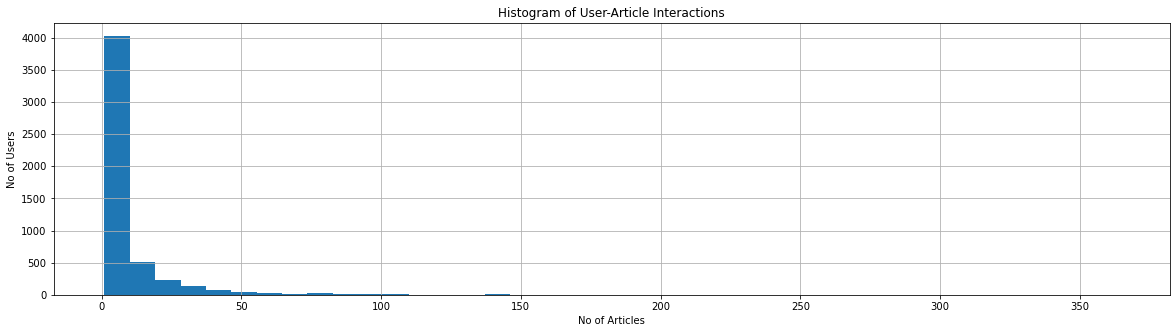

In [130]:
fig = plt.figure(figsize=(20,5))
ax = fig.gca()

temp = df.email.value_counts().reset_index().rename(columns={'email': 'articles', 'index':'user'})
temp.hist(column=['articles'], bins=40, ax=ax)

plt.title("Histogram of User-Article Interactions")
plt.xlabel("No of Articles")
plt.ylabel("No of Users")
plt.show()

In [139]:
# Fill in the median and maximum number of user_article interactios below
median_val = temp.articles.median()
max_views_by_user = temp.articles.max()

print(f"""There are {color.BOLD}{temp.user.count():,}{color.END} users on the platform
50% of individuals interact with {color.BOLD}{median_val:.0f}{color.END} number of articles or fewer.
The maximum number of user-article interactions by any 1 user is {bold(max_views_by_user)}""")

There are 5,148 users on the platform
50% of individuals interact with 3 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [283]:
dup_body = df_content.doc_body.duplicated()
dup_article_id_name = df_content.article_id.duplicated()

print(f"""There are {bold(dup_article_id_name.sum())} duplicated articles_ids or doc_full_names in df_content
There are {bold(dup_body.sum())} duplicated doc_body values in df_content
I will only drop the articles that have duplicate article_ids for now.""")

There are 5 duplicated articles_ids or doc_full_names in df_content
There are 19 duplicated doc_body values in df_content
I will only drop the articles that have duplicate article_ids for now.


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [209]:
unique_articles = df.article_id.nunique() # The number of unique articles that have at least one interaction
unique_articles_content = len(set(df.article_id).intersection(df_content.article_id)) # The number of unique articles that have at least one interaction
total_articles = df_content.article_id.nunique() # The number of unique articles on the IBM platform
unique_users = df.email.dropna().nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

print(f"""
Answers:
\ta. The number of unique articles that have an interaction with a user: {color.BOLD}{unique_articles}{color.END}
\ta. The number of unique articles that have an interaction with a user and who's content is available in df_content: {color.BOLD}{unique_articles_content}{color.END}
\tb. The number of unique articles in the dataset (whether they have any interactions or not): {color.BOLD}{total_articles:,}{color.END}
\tc. The number of unique users in the dataset. (excluding null values): {color.BOLD}{unique_users:,}{color.END}
\td. The number of user-article interactions in the dataset: {color.BOLD}{user_article_interactions:,}{color.END}
""")


Answers:
	a. The number of unique articles that have an interaction with a user: 714
	a. The number of unique articles that have an interaction with a user and who's content is available in df_content: 437
	b. The number of unique articles in the dataset (whether they have any interactions or not): 1,051
	c. The number of unique users in the dataset. (excluding null values): 5,148
	d. The number of user-article interactions in the dataset: 45,993



`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [183]:
temp = df.article_id.value_counts()
most_viewed_article_id = str(temp.index[0]) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = temp.iloc[0] # The most viewed article in the dataset was viewed how many times?

print(f"""most_viewed_article_id: {bold(most_viewed_article_id)}
max_views: {bold(max_views)}""")

most_viewed_article_id: 1429.0
max_views: 937


In [217]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [210]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


In [218]:
df['article_id'] = df.article_id.astype(int)

### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [179]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    grouped_df = df.groupby('article_id').agg({'title': lambda x:x.iloc[0], 'user_id': 'count'}).sort_values(by='user_id', ascending=False)
    top_articles = grouped_df.title.iloc[:n].tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df.article_id.value_counts().index[:n].tolist()
    
    return top_articles # Return the top article ids

In [232]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


In [233]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [253]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item_mat = df.pivot_table(values='title', index='user_id', columns='article_id', aggfunc=lambda x: 1, fill_value=0)
    
    return user_item_mat # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [243]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [289]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
        '''
    users_id_list = user_item.index.values

    row = np.where(users_id_list == user_id)[0][0]
    user_item_mat = user_item.values
    similarity = user_item_mat[row, :].dot(user_item_mat.T)
    
    similarity = similarity[users_id_list != user_id]
    users_id_list = users_id_list[users_id_list != user_id]
    
    similarity_idx = np.argsort(similarity)[::-1]
    
    most_similar_users = users_id_list[similarity_idx]
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [290]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933   23 3782  203 4459 3870  131 4201   46 3697]
The 5 most similar users to user 3933 are: [   1 3782   23  203 4459]
The 3 most similar users to user 46 are: [4201 3782   23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [196]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    title_dict = dict(zip(df.article_id, df.title))
    article_names = list(map(title_dict.get, list(article_ids)))
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, df=df):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    summary = df.query("user_id == @user_id")[['article_id', 'title']].drop_duplicates()
    
    article_ids = summary.article_id.tolist()
    article_names = summary.title.tolist()

    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    recs = []

    # read articles
    article_ids_orig, article_names_orig = get_user_articles(user_id)
    
    similar_user_id = find_similar_users(user_id)
    
    for similar_ in similar_user_id:
        article_ids, article_names = get_user_articles(similar_)
        
        rec_ids_diff = list(np.setdiff1d(article_ids, article_ids_orig, assume_unique=True))
        recs += rec_ids_diff
        
        if len(recs) >= m:
            break
    
    return recs[:m] # return your recommendations for this user_id    

In [323]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['dsx: hybrid mode',
 'using github for project control in dsx',
 'accelerate your workflow with dsx',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'experience iot with coursera',
 'data visualization playbook: telling the data story',
 'gosales transactions for logistic regression model',
 'shaping data with ibm data refinery',
 'the unit commitment problem',
 'programmatic evaluation using watson conversation']

In [329]:
def conv_to_int(list_):
    return [int(float(i)) for i in list_]

In [333]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(conv_to_int(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0']))) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(conv_to_int(['1320.0', '232.0', '844.0']))) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(conv_to_int(['1320.0', '232.0', '844.0']))
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(conv_to_int(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0']))
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [10]:
user_interaction_dict = df.groupby('user_id')['article_id'].count().to_dict()

In [11]:
article_interaction_dict = df.groupby('article_id')['user_id'].count().to_dict()

In [347]:
user_id = 2
users_id_list = user_item.index.values

row = np.where(users_id_list == user_id)[0][0]
user_item_mat = user_item.values
similarity = user_item_mat[row, :].dot(user_item_mat.T)

similarity = similarity[users_id_list != user_id]
users_id_list = users_id_list[users_id_list != user_id]

sim_df = pd.DataFrame({'user_id':users_id_list, 'similarity': similarity})
sim_df['interactions'] = sim_df.user_id.map(user_interaction_dict)
sim_df.sort_values(by=['similarity','interactions'], ascending=False)

,user_id,similarity,interactions
96,98,5,170
3762,3764,5,169
47,49,5,147
3695,3697,5,145
21,23,4,364
...,...,...,...
5139,5141,0,1
5142,5144,0,1
5145,5147,0,1
5146,5148,0,1


In [351]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    users_id_list = user_item.index.values

    row = np.where(users_id_list == user_id)[0][0]
    user_item_mat = user_item.values
    similarity = user_item_mat[row, :].dot(user_item_mat.T)

    similarity = similarity[users_id_list != user_id]
    users_id_list = users_id_list[users_id_list != user_id]

    neighbors_df = pd.DataFrame({'user_id':users_id_list, 'similarity': similarity})
    neighbors_df['interactions'] = neighbors_df.user_id.map(user_interaction_dict)
    neighbors_df = neighbors_df.sort_values(by=['similarity','interactions'], ascending=False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    recs = []

    # read articles
    article_ids_orig, article_names_orig = get_user_articles(user_id)
    
    similar_user_id = get_top_sorted_users(user_id).user_id
    
    for similar_ in similar_user_id:
        article_ids, article_names = get_user_articles(similar_)
        
        article_ints = list(map(article_interaction_dict.get, article_ids))
        article_ints_idx = np.argsort(article_ints)[::-1]
        
        rec_ids_diff = list(np.setdiff1d(np.array(article_ids)[article_ints_idx], article_ids_orig, assume_unique=True))
        recs += rec_ids_diff
        
        if len(recs) >= m:
            break
    
    return recs[:m] , get_article_names(recs[:m])

In [352]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330, 1427, 1364, 1170, 1162, 1304, 1351, 1160, 1354, 1368]

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [364]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).user_id.iloc[0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).user_id.iloc[9] # Find the 10th most similar user to user 131

In [366]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

Answer:
1. We would use the rank based recommendations for the new user i.e. `get_top_articles()` or `get_top_article_ids()` function
1. If we go beyond our current dataset and **try to gather data about this new user** (e.g. Using their IP address to get country they're connecting or using the personal information provided during registration), we can use this to perform a User-user based collaborative filtering recommendation for these new users.
1. We could also use **a mix of content and rank-based** recommendations to recommend top articles as well as new articles that are similar to the top articles.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [373]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(n=10) # Your recommendations here

In [374]:
assert set(new_user_recs) == set(conv_to_int(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0'])), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

In [46]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
from multiprocessing import Pool
from multiprocessing_fn import clean_body

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ktmbugua\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ktmbugua\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
df_content_recs = df_content.copy()

# Dropping duplicates based on article bodies
df_content_recs = df_content_recs.drop_duplicates(subset=['doc_body'])
df_content_recs = df_content_recs[~pd.isnull(df_content_recs['doc_body'])]

df_content_recs['article_int'] = df_content_recs.article_id.map(article_interaction_dict)

In [31]:
total_articles = df_content_recs.shape[0]
print(f"Only {bold(total_articles - df_content_recs.article_int.isna().sum())} articles within the df_content dataset have been interacted with by the users out of {bold(total_articles)} articles")

Only 437 articles within the df_content dataset have been interacted with by the users out of 1036 articles


In [205]:
body_list = df_content_recs.doc_body.tolist()

def clean_body_list(body_list_):
    """
    This method cleans the doc_body column using the multiprocessing library
    
    :param body_list_: This is a list of raw body text
    :return: List of clean tokenized body texts.
    """
    with Pool(6) as pool:
        tokenized_corpus_list_ = pool.map(clean_body, body_list_)
        
    return tokenized_corpus_list_

In [35]:
%%time
tokenized_corpus_list = clean_body_list(body_list)

Wall time: 2min 26s


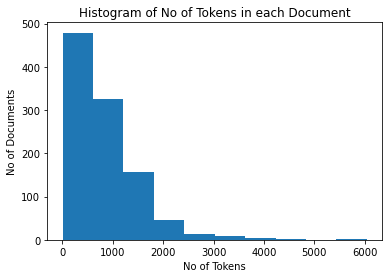

In [168]:
plt.hist(np.array([len(i) for i in tokenized_corpus_list]))

plt.title("Histogram of No of Tokens in each Document")
plt.xlabel("No of Tokens")
plt.ylabel("No of Documents")
plt.show()

In [169]:
%%time
# Build Vocab and Doc2Vec model
corpus_list_tagged = [gensim.models.doc2vec.TaggedDocument(tokens, [i]) for i,tokens in enumerate(tokenized_corpus_list)]

model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=40)

model.build_vocab(corpus_iterable=corpus_list_tagged)

model.train(corpus_list_tagged, total_examples=model.corpus_count, epochs=model.epochs)

Wall time: 18.5 s


In [147]:
%%time
# Build Similarity Matrix
corpuses_len = len(corpus_list_tagged)

body_similarity_matrix = np.zeros(shape=(corpuses_len,corpuses_len))
for idx in list(zip(np.repeat(np.arange(corpuses_len), corpuses_len), np.tile(np.arange(corpuses_len), corpuses_len))):
    body_similarity_matrix[idx] = model.docvecs.distance(*idx)

C:\Users\ktmbugua\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  


Wall time: 21.8 s


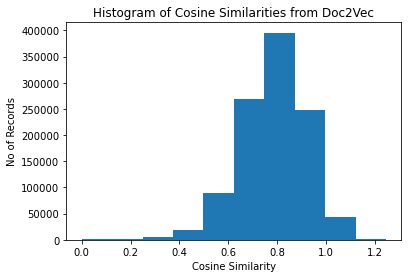

In [167]:
plt.hist(body_similarity_matrix.flatten())

plt.title("Histogram of Cosine Similarities from Doc2Vec")
plt.xlabel("Cosine Similarity")
plt.ylabel("No of Records")
plt.show()

In [162]:
def make_content_recs(article_id, sim_matrix=body_similarity_matrix, df_content_=df_content_recs):
    """
    This method makes content based recommendations using a similarity matrix created using the Doc2Vec library.

    :param artcile_id:
    :param similarity_mat: Similarity matrix based on the doc_body column
    :param df_content_: Dataframe that contains article content data
    :return: Content based recommendations
    """
    article_id_list = df_content_.article_id.values
    art_id_bool = article_id_list == article_id
    idx = np.where(art_id_bool)[0][0]

    # We remove the requested art_id from the artical_similarities output
    article_similarities = sim_matrix[idx,:][~art_id_bool]

    art_sim_idx_list = np.argsort(article_similarities)

    sorted_art_id_list = article_id_list[~art_id_bool][art_sim_idx_list]

    return sorted_art_id_list

def get_article_full_name(article_ids, n=10,  df=df_content_recs):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    n - No of names to return
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    title_dict = dict(zip(df.article_id, df.doc_full_name))
    article_names = list(map(title_dict.get, list(article_ids)))
    
    return article_names[:n] # Return the article names associated with list of article ids

In [165]:
get_article_full_name([1]), get_article_full_name(make_content_recs(1))

(['Communicating data science: A guide to presenting your work'],
 ['May 2016: Scripts of the Week',
  '10 pieces of advice to beginner data scientists',
  'Data Visualization Playbook: Telling the Data Story',
  'Collecting Data Science Cheat Sheets',
  'Let data dictate the visualization',
  'The Data Processing Inequality',
  'Spark-based machine learning tools for capturing word meanings',
  'Word2Vec in Data Products',
  '10 Data Science Podcasts You Need To be Listening To Right Now',
  'Got a PhD? Struggling To Be a Data Scientist?'])

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?


**Write an explanation of your content based recommendation system here.**

Explaination:  
The recommender first cleans and tokenizes the doc_body column using an NLP Pipeline. It then uses **Doc2Vec library** to create document-level representations of each article. Finally I use **cosine similarity** as my distance metric to detect similar articles. The function `make_content_recs()` then makes content recommendations based on the article_id that's passed.

Possible Improvements  
1. Yes. I could get an updated version of `df_content`. That could allow me to make content based recommendations on the entire database
1. Include the `doc_full_name` and `doc_description` columns in the document tokens.
1. Try out newer techniques such as GloVe

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

**NB**: df_content is an old dataset. It does not have the content for the latest articles i.e. article_id greater than **1050**

In [203]:
# make recommendations for a brand new user
# Here, I use a mix of content and rank based recommendations for a new user
top_article_ids = get_top_article_ids(15)

similar_articles = []
for art in top_article_ids:
    try:
        # Unfortunately, df_content is an old dataset. It does not have the content for the latest articles i.e. article_id > 1050
        similar_articles += get_article_full_name(make_content_recs(art), n=5)
    except:
        continue

all_recs = get_article_names(top_article_ids) + similar_articles
all_recs

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'finding optimal locations of new store using decision optimization',
 'apache spark lab, part 1: basic concepts',
 'analyze energy consumption in buildings',
 'gosales transactions for logistic regression model',
 'welcome to pixiedust',
 'customer demographics and sales',
 'total population by country',
 'deep learning with tensorflow course by big data university',
 'model bike sharing data with spss',
 'Learn TensorFlow and Deep Learning Together and Now!',
 'This Week in Data Science (February 28, 2017)',
 'Deep Learning From Scratch I: Computational Graphs',
 'This Week in Data Science (March 7, 2017)',
 'This Week in Data Science (May 2, 2017)']

In [201]:
# make a recommendations for a user who only has interacted with article id '1427.0'
# This fails because we do not have body content for this article. Unfortunately, df_content is an old dataset. It does not have the content for the 
# latest articles i.e. article_id > 1050

# Using article_id 1050 instead
get_article_full_name([1050]), get_article_full_name(make_content_recs(1050))

(['Jupyter Notebooks with Scala, Python, or R Kernels'],
 ['Tidy up your Jupyter notebooks with scripts',
  'Jupyter Notebook Tutorial',
  'PixieDust: Magic for Your Python Notebook',
  'Back to basics — Jupyter notebooks',
  'Upload data and create Data Frames in Jupyter Notebooks',
  'Brunel In Jupyter',
  'Enjoy Python 3.5 in Jupyter Notebooks',
  'Create a replication job',
  'Collecting Data Science Cheat Sheets',
  'Using Brunel in IPython/Jupyter Notebooks'])

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [206]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [225]:
user_item_matrix.columns = user_item_matrix.columns.values.astype(float).astype(int)

In [226]:
# quick look at the matrix
user_item_matrix.head()

,0,100,1000,1004,1006,1008,101,1014,1015,1016,...,977,98,981,984,985,986,990,993,996,997
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [208]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix.values)  # use the built in to get the three matrices

In [210]:
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

**Provide your response here.**

It's because we have no missing values in the matrix. Since the data the matrix is binary both null/0 and 1 have meaning. For this reason, there are no missing values in the matrix.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

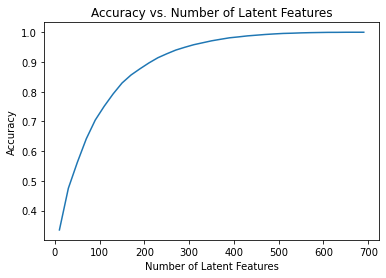

In [476]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [240]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = df_train.pivot_table(values='title', index='user_id', columns='article_id', aggfunc=lambda x: 1, fill_value=0)
    user_item_test = df_test.pivot_table(values='title', index='user_id', columns='article_id', aggfunc=lambda x: 1, fill_value=0)
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns.values
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

The test below was failing because it **hasn't been updated** for this project!  

I have answered the questions below the test cell.

In [261]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

KeyError: 'How many movies can we make predictions for in the test set?'

In [483]:
user_preds_test = len(set(df_test.user_id).intersection(df_train.user_id))
articles_preds_test = user_item_test.shape[1]
cold_start_test_users = user_item_test.shape[0] - user_preds_test

cold_start_articles = len(np.setdiff1d(df_content.article_id.values, df.article_id.values))
cold_start_test_articles = 0

print(f"""
    How many users can we make predictions for in the test set?: {bold(user_preds_test)}, 
    How many users in the test set are we not able to make predictions for because of the cold start problem?: {bold(cold_start_test_users)}, 
    How many articles can we make predictions for in the test set?: {bold(articles_preds_test)},
    How many articles in the test set are we not able to make predictions for because of the cold start problem?: {bold(cold_start_test_articles)}
""")


    How many users can we make predictions for in the test set?: 20, 
    How many users in the test set are we not able to make predictions for because of the cold start problem?: 662, 
    How many articles can we make predictions for in the test set?: 574,
    How many articles in the test set are we not able to make predictions for because of the cold start problem?: 0



`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [499]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train.values, full_matrices=True) # fit svd similar to above then use the cells below

In [500]:
u_train = u_train[:, :len(s_train)]
s_train = np.diag(s_train)

In [505]:
predictable_user_ids = list(set(df_test.user_id).intersection(df_train.user_id))
predict_articles = df_test.article_id.sort_values().unique()

testable_interaction_df = df_test[df_test.user_id.isin(predictable_user_ids)]
user_item_test_filtered_matrix = user_item_test.loc[predictable_user_ids, predict_articles].values

predictable_user_idx = np.where(user_item_train.index.isin(predictable_user_ids))[0]
predictable_article_idx = np.where(user_item_train.columns.isin(predict_articles))[0]

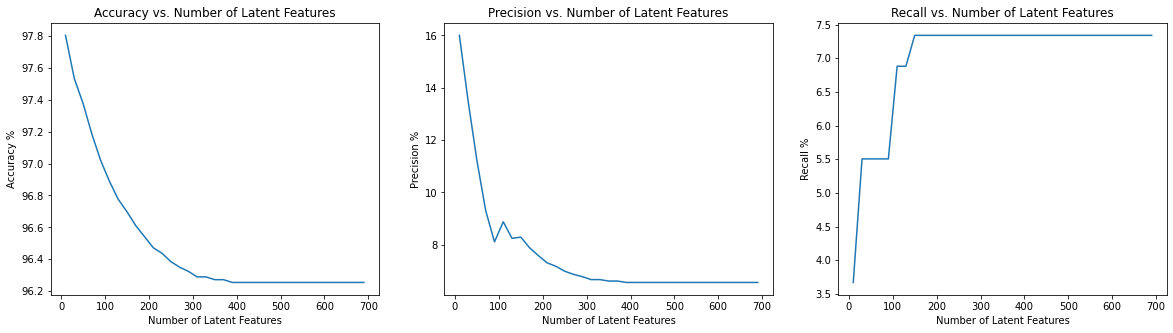

Wall time: 454 ms


In [644]:
%%time
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []
precision = []
recall = []

vt_train_filtered = vt_train[:, predictable_article_idx]  # We filter out the 574 articles we're able to predict on 
u_train_filtered = u_train[predictable_user_idx, :] # We filter out the 20 users we're able to predict on 
interaction_bool = user_item_test_filtered_matrix == 1
total_interactions = np.sum(user_item_test_filtered_matrix)

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = s_train[:k,:k], u_train_filtered[:, :k], vt_train_filtered[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # We descretize the predictions
    user_item_est[user_item_est >= 0.5] = 1
    user_item_est[user_item_est < 0.5] = 0
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test_filtered_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    pred_interaction_bool = user_item_est == 1
    user_item_test_filtered_matrix[pred_interaction_bool].sum()
    
    true_positives = user_item_est[interaction_bool].sum()
    
    precision.append(true_positives/user_item_est.sum())
    recall.append(true_positives/total_interactions)

plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)    
plt.plot(num_latent_feats, (1 - np.array(sum_errs)/(574*20))*100)
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy %')
plt.title('Accuracy vs. Number of Latent Features')

# We use classification metrics to evaluate the performance of the recommendations
plt.subplot(1, 3, 2)    
plt.plot(num_latent_feats, np.array(precision)*100)
plt.xlabel('Number of Latent Features')
plt.ylabel('Precision %')
plt.title('Precision vs. Number of Latent Features')

plt.subplot(1, 3, 3)    
plt.plot(num_latent_feats, np.array(recall)*100)
plt.xlabel('Number of Latent Features')
plt.ylabel('Recall %')
plt.title('Recall vs. Number of Latent Features')

plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

Comments on the above results:
- The results above are not the best. Accuracy could not give a clear picture because the dataset was imbalanced so I used the classification metrics, Precision and Recall, to help me understand the performance of the recommender.
- Precision is very low (at 16% peak). The precision and accuracy drop as the number of latent features increase. This result suggests that adding latent features to the matrices also adds noise. Also, using more than 300 features adds no appreciable benefit to the recommender's performance.

How I might determine if above recommendations are an improvement:  
- Given that the results for the above SVD recommender are poor, I would first **improve the performance of the recommender**. 
- However, once the above is done, I would design an experiment i.e. an **AB Test**.
- The aim of this experiment would be to determine if the recommender **increases a user's article interactions** by a pre-determined **practical significance level**.

In [648]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0